# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 07' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**

## Load packages

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [3]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

## Modelo Auto-regressivo Sazonal de Média Móveis Integrado (SARIMA)

Apesar do método ARIMA ser capaz de lidar com tendências em séries temporais, o mesmo não possui a capacidade de lidar com variáveis sazonais. Ou seja, séries com ciclos que se repetem. O método ARIMA assume que os dados não são sazonais ou que a sazonalidade foi removida no processo de diferenciação.

O "Seasonal Autoregressive Integrated Moving Average", SARIMA ou ARIMA Sazonal, é uma extenção do ARIMA que suporta, de maneira explícita, séries temporais com componente sazonal através da adição de três novos parâmetros para especificar a autoregressão (AR), diferenciação (I) e média móvel (MA) para a componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

### Configurando o SARIMA
Para configurar o SARIMA precisamos selecionar os parâmetros para os elementos de tendência e sazonalidade da série.

#### Elementos de tendência
Existem três elementos de tendência. Estes são os mesmos do modelo ARIMA.

* $p$: Ordem do AR
* $d$: Ordem de diferenças
* $q$: Ordem do MA

#### Elementos sazonais
Existem quatro elementos sazonais que não fazem parte do ARIMA

* $P$: Ordem do AR sazonal
* $D$: Odem de diferenças sazonais
* $Q$: Ordem do MA sazonal
* $s$: Número de períodos referentes ao ciclo sazonal

A notação final do SARIMA é definida como SARIMA($p$,$d$,$q$)($P$,$D$,$Q$)$s$.

É importante salientar que a escolha dos valores dos parâmetro sazonais $P$, $D$ e $Q$ é influenciada pelo valor $s$, e.g., um modelo com $s=12$ meses sugere uma sazonalidade com ciclo anual, assim, $P=2$ sugere que existe dependência linear entre do valor do período $t$ e os valores dos períodos $(t-s)$ e $(t-s\times 2)$.

Tomemos o exemplo das informações sobre número de queimadas no Brasil contidas no arquivo ```fire.csv```.

In [4]:
Path = ""

data = pd.read_csv(Path+"data/fire.csv")
print(data.shape)
data.head()

(6454, 3)


,state,number,Month
0,Acre,0.0,1998-1
1,Acre,0.0,1999-1
2,Acre,0.0,2000-1
3,Acre,0.0,2001-1
4,Acre,0.0,2002-1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   6454 non-null   object 
 1   number  6454 non-null   float64
 2   Month   6454 non-null   object 
dtypes: float64(1), object(2)
memory usage: 151.4+ KB


In [6]:
data.describe()

,number
count,6454.000000
mean,108.293163
std,190.812242
min,0.000000
25%,3.000000
50%,24.000000
75%,113.000000
max,998.000000


In [7]:
train = data.copy()

In [8]:
train.Month = pd.to_datetime(data["Month"])
train.set_index('Month', inplace=True)
train.sort_index(inplace=True)
train.head()

,state,number
Month,,
1998-01-01,Acre,0.0
1998-01-01,Paraiba,0.0
1998-01-01,Pará,0.0
1998-01-01,Rio,0.0
1998-01-01,Tocantins,0.0


In [9]:
train.state.unique()

array(['Acre', 'Paraiba', 'Pará', 'Rio', 'Tocantins', 'Minas Gerais',
       'Sergipe', 'Mato Grosso', 'Piau', 'Goias', 'Espirito Santo',
       'Alagoas', 'Distrito Federal', 'Roraima', 'Ceara', 'Bahia',
       'Santa Catarina', 'Amazonas', 'Amapa', 'Sao Paulo', 'Rondonia',
       'Maranhao', 'Pernambuco'], dtype=object)

Temos várias opções de estados na coluna ```state```. Para esse exemplo, nos concentraremos no estado do Amapa. Criaremos assim, uma novo ```DataFrame``` chamado ```df1```contendo somente os dados associados ao estado do Amapa.

<AxesSubplot:xlabel='Month'>

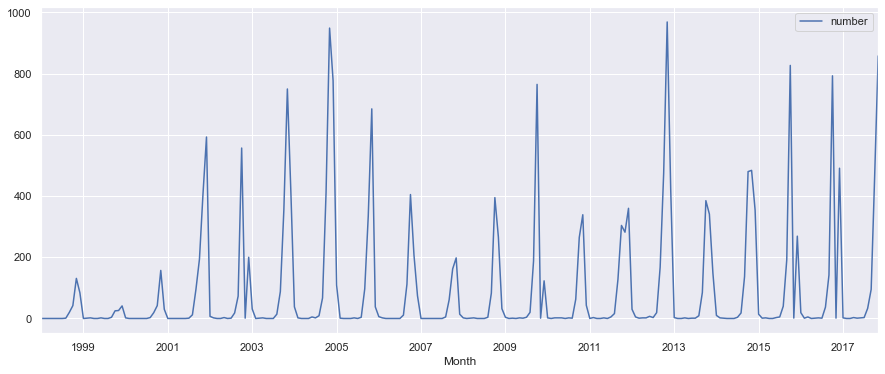

In [10]:
df1 = train[train.state == 'Amapa']
df1.plot(figsize=(15, 6))

Precisamos analisar a compomente de sazonalidade. Para tanto, faremos o agrupamento dos dados por mês com o objetivo de verificar se existe padrão de sazonalidade associado aos meses do ano.

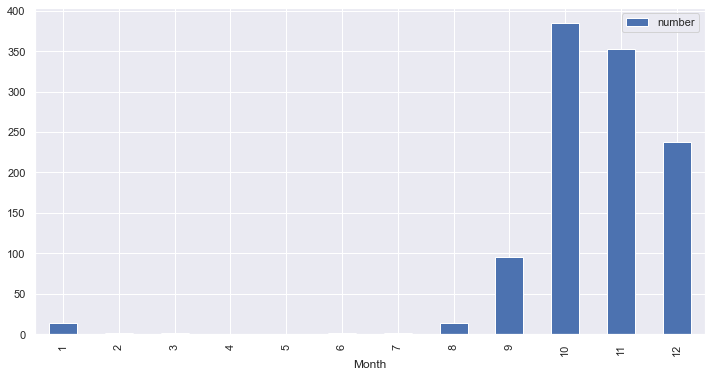

In [11]:
df1.groupby(df1.index.month).mean().plot(kind='bar', figsize=(12, 6));

Analisando o gráfico acima, percebemos que, em média, o número de queimadas no segundo semestre é maior que no primeiro semestre, com pico no mês de Outubro e mínimo no mês de Abril. O padrão sugeste uma ciclagem anual, i.e., $s=12$ meses. 

Analisando os gráficos da autocorrelação parcial e total, confirmamos a presença de sazonalidade autocorrelacionada.

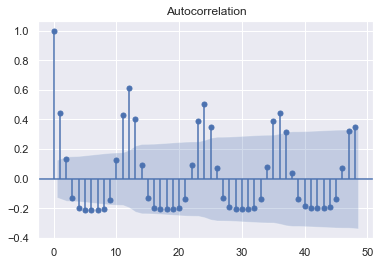

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df1.number, alpha=0.05, lags=48);

<Figure size 864x432 with 0 Axes>

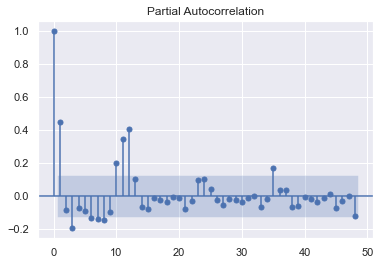

In [13]:
fig = plt.figure(figsize=(12, 6))

plot_pacf(df1.number, alpha=0.05, lags=48);

Para analisar a estacionaridade para a componente sazonal, faremos a plotagem da série temporal para cada mês. Para tando, utilizaremos o comando ```DataFrame.groupby()```.

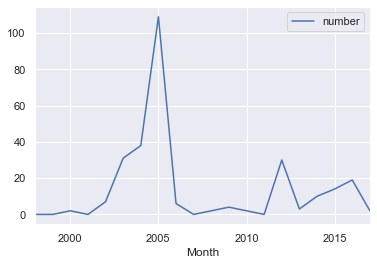

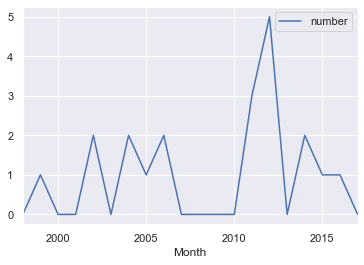

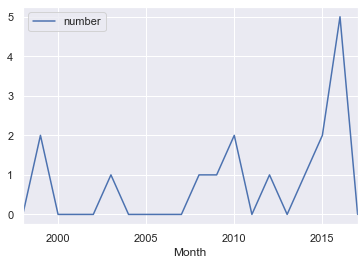

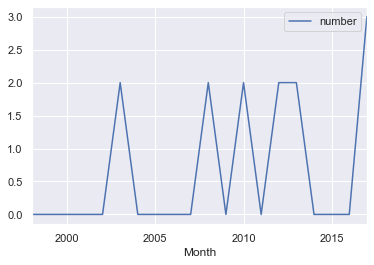

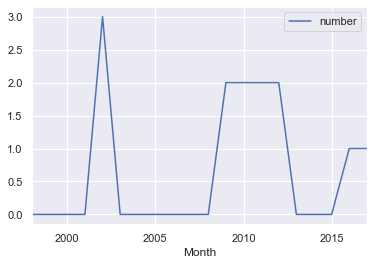

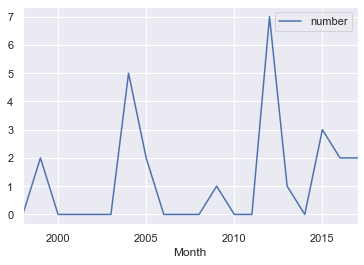

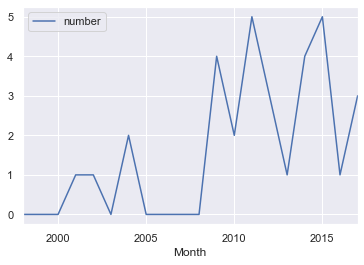

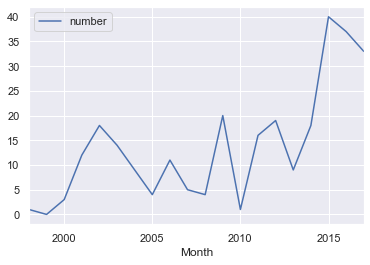

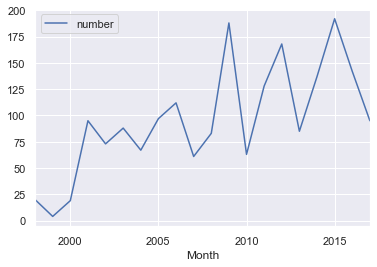

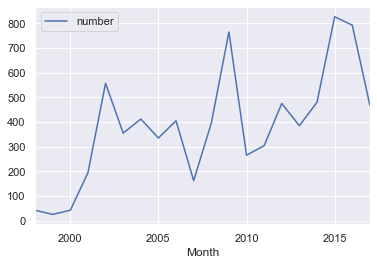

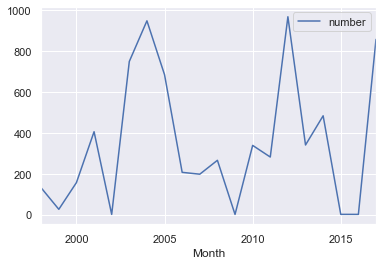

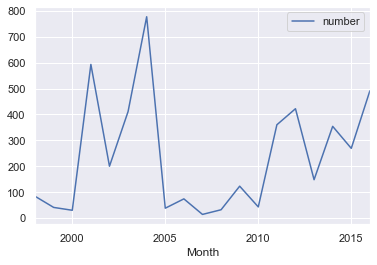

In [14]:
df1.groupby(df1.index.month).plot();

Para boa tarde das séries observamos um padrão não estacionário.

Para utilizar o SARIMA faremos a importação da classe ```SARIMAX``` presente no subpacote ```statsmodels.tsa.statespace.sarimax```. Os parâmetros de tendência $p$, $d$ e $q$ são configurados através do parâmetro ```order=(p, d, q)``` e os parâmetro de sazonalidade $P$, $D$, $Q$ e $s$ são configurados através do parâmetro ```seasonal_order=(P, D, Q, s)```.

Faremos um teste com a configuração SARIMA(2, 1, 2)(3, 1, 2)12.

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(df1.number, freq='MS', order=(2, 1, 2), seasonal_order=(3, 1, 2, 12)).fit()
(sarima.resid ** 2).mean()

C:\Users\marcu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


16353.824989108432

Faremos a comparação da mesma configuração para o modelo ARIMA.

In [16]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(df1.number, freq='MS', order=(2, 1, 2)).fit()
(arima.resid ** 2).mean()

26336.947566581224

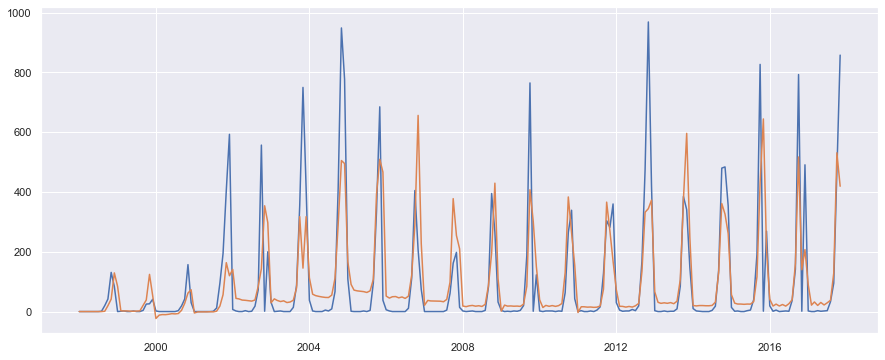

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df1.number)
plt.plot(sarima.predict(typ='levels'));
# plt.plot(arima.predict(typ='levels'));

In [22]:
df1.index

DatetimeIndex(['1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01',
               '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01',
               '1998-09-01', '1998-10-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='Month', length=239, freq=None)

In [23]:
sarima.forecast()[0]

470.7096310531092

In [26]:
sarima.forecast()

2017-12-01    470.709631
Freq: MS, dtype: float64